In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'/'CV Project'/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CV Project


In [2]:
import os
import datetime
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image, ImageChops, ImageEnhance

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint



In [4]:
def get_ela(dir, filename):
    path = os.path.join(dir, filename)
    temp_img = 'tmp_img_bw.jpg'

    image = Image.open(path)
    filtered_image = image.convert('RGB').filter(ImageFilter.BoxBlur(0.5))
    filtered_image.save(temp_img, 'JPEG', quality = 90)
    
    temp_image = Image.open(temp_img)
    
    ela_image = ImageChops.difference(filtered_image, temp_image)
    
    extremas = ela_image.getextrema()
    max_ext = max([x[1] for x in extremas])
    if max_ext == 0:
        scale = 255.0
    else:
        scale = 255.0 / max_ext
    
    ela_image = ImageEnhance.Brightness(ela_image)
    ela_image = ela_image.enhance(scale)

    result = np.array(ela_image.resize((128,128))).flatten()/255

    return result

In [5]:
authentic_path = '/scratch/ap6624/CV/casia2groundtruth/CASIA2.0_revised/Au'
tampered_path = '/scratch/ap6624/CV/casia2groundtruth/CASIA2.0_revised/Tp'

X_arr = []
y_arr = []

for dir, _, files in os.walk(authentic_path):
    for filename in tqdm(files):
        if filename.endswith('jpg') or filename.endswith('png'):
            X_arr.append(get_ela(dir, filename))
            y_arr.append(0)

num_authentic = len(X_arr)
print("Authentic Images:", num_authentic)

for dir, _, files in os.walk(tampered_path):
    for filename in tqdm(files):
        if filename.endswith('jpg') or filename.endswith('png'):
            X_arr.append(get_ela(dir, filename))
            y_arr.append(1)
            
print("Tampered Images:", len(X_arr) - num_authentic)

X = np.array(X_arr)
# X = X_arr
y = y_arr

print("Shape of Train Data")
print(X.shape)

 92%|█████████▏| 6904/7492 [02:29<00:10, 55.93it/s]/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)
100%|██████████| 7492/7492 [02:42<00:00, 46.12it/s]


Authentic Images: 7437


100%|██████████| 5123/5123 [01:10<00:00, 72.61it/s] 


Tampered Images: 2064
Shape of Train Data
(9501, 49152)


In [6]:
X = np.array(X_arr)
y = y_arr

print(X.shape)

y = to_categorical(y, 2)
X = X.reshape(-1, 128, 128, 3)
print(X.shape)

(9501, 49152)
(9501, 128, 128, 3)


In [8]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(7600, 128, 128, 3) (7600, 2)
(1901, 128, 128, 3) (1901, 2)


In [ ]:
# X_save_path = 'ELA_extracted_X.npy'
# y_save_path = 'ELA_extracted_y.npy'
# with open(X_save_path, 'wb') as f1:
#     np.save(f1, X)
# with open(y_save_path, 'wb') as f2:
#     np.save(f2, y)

##Using a Basic CNN

In [10]:

basicCNNModel = Sequential()
basicCNNModel.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(128,128,3), padding="same", activation='relu'))
basicCNNModel.add(Dropout(0.25))
basicCNNModel.add(Conv2D(64, kernel_size=3, strides=2, padding="same", activation='relu'))
basicCNNModel.add(BatchNormalization(momentum=0.8))
basicCNNModel.add(Dropout(0.25))
basicCNNModel.add(Conv2D(128, kernel_size=3, strides=2, padding="same", activation='relu'))
basicCNNModel.add(BatchNormalization(momentum=0.8))
basicCNNModel.add(Dropout(0.25))
basicCNNModel.add(Conv2D(256, kernel_size=3, strides=1, padding="same", activation='relu'))
basicCNNModel.add(BatchNormalization(momentum=0.8))
basicCNNModel.add(Dropout(0.25))
basicCNNModel.add(Flatten())
basicCNNModel.add(Dense(256, activation = "relu"))
basicCNNModel.add(Dropout(0.5))
basicCNNModel.add(Dense(2, activation = "softmax"))


basicCNNModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                        

In [11]:
checkpoint_filepath = 'BasicCNNwithBatchNorm_Detection/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

epochs = 10
batch_size = 32
opt = RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)

early_stopping = EarlyStopping(monitor = 'val_accuracy',patience = 2,mode = 'auto', min_delta = 0)

basicCNNModel.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [12]:
epochs = 10
batch_size = 32
aug = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, fill_mode="nearest")

# basicCNNModel.fit(X_train,y_train,batch_size = batch_size,epochs = epochs,validation_data = (X_test, y_test),callbacks = [early_stopping, model_checkpoint_callback])

basicCNNModel.fit_generator(aug.flow(X_train, y_train, batch_size =  batch_size), steps_per_epoch=(len(X_train) /batch_size),epochs = epochs,validation_data = (X_test, y_test),callbacks = [early_stopping, model_checkpoint_callback])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10
237/237 [==============================] - 34s 105ms/step - loss: 0.5785 - accuracy: 0.8011 - val_loss: 0.5780 - val_accuracy: 0.5197
Epoch 2/10
237/237 [==============================] - 25s 106ms/step - loss: 0.3986 - accuracy: 0.8267 - val_loss: 0.4593 - val_accuracy: 0.7864
Epoch 3/10
237/237 [==============================] - 24s 103ms/step - loss: 0.3607 - accuracy: 0.8272 - val_loss: 0.6392 - val_accuracy: 0.6549
Epoch 4/10
237/237 [==============================] - 24s 101ms/step - loss: 0.3360 - accuracy: 0.8324 - val_loss: 0.5776 - val_accuracy: 0.6191


              precision    recall  f1-score   support

           0       0.89      0.59      0.71      1496
           1       0.32      0.73      0.45       405

    accuracy                           0.62      1901
   macro avg       0.61      0.66      0.58      1901
weighted avg       0.77      0.62      0.65      1901



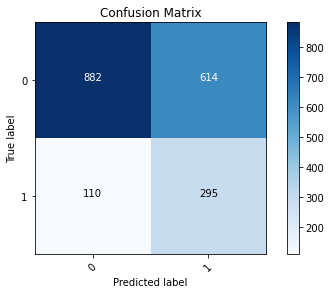

In [13]:

y_pred = basicCNNModel.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1) 

cfm = confusion_matrix(y_true, y_pred_classes) 
plot_confusion_matrix(cfm, classes = range(2))

from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes))